# Set up Enviroment

In [105]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import joblib
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

In [106]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [107]:
tokens = ["btc", "eth", "xrp"]
train_test_split = ["721", "622", "811"]

data_source = '/content/drive/My Drive/Report_DBA/final_report/'
processed_output_dir = os.path.join(data_source,  "processing/")

targets = ["Close"]

data_set = {1: "train", 2: "test", 3: "validation"}

model_name = "xgboost"

T = 60 # ----> lookback
TF = 1 # ----> predict
NFeature = 1 # ----> feautures

# working on
token_id = 2
# n_split = 0 # 721
# n_split = 1 # 622
n_split = 2 # 811

In [108]:
%cd $data_source

/content/drive/My Drive/Report_DBA/final_report


In [109]:
# load scaler
scaler = joblib.load(os.path.join(f"{processed_output_dir}/{tokens[token_id]}/{train_test_split[n_split]}", f"{targets[0]}_train_scalerMinMaxNorm.save"))

# Get raw data

In [110]:
def getData(data_dir = "processing", subset = "train", token_id  = 0):
    df = pd.read_excel(f"{data_dir}/{tokens[token_id]}/{train_test_split[n_split]}/{targets[0]}_{subset}_scaler.xlsx")
    df.drop(columns=["Unnamed: 0"], inplace=True)
    return df

# Define supervised data

In [111]:
def getSupervisedData(T, TF, train, test, val):

    # TRAIN
    series = train.to_numpy()
    X = []
    Y = []
    for t in range(len(series) - T - TF + 1):
      x = series[t:t+T,-1]
      X.append(x)

      y = series[t+T:t+T+TF,-1]
      Y.append(y)
    Xtrain = np.array(X).astype(float)
    Ytrain = np.array(Y).astype(float).reshape(len(Y),)

    # TEST
    series = np.concatenate([train.to_numpy()[-T:],test.to_numpy()])
    X = []
    Y = []
    for t in range(len(series) - T - TF + 1):
      x = series[t:t+T,-1]
      X.append(x)

      y = series[t+T:t+T+TF,-1]
      Y.append(y)
    Xtest = np.array(X).astype(float)
    Ytest = np.array(Y).astype(float).reshape(len(Y),)

    # VAL
    series = np.concatenate([test.to_numpy()[-T:],val.to_numpy()])
    X = []
    Y = []
    for t in range(len(series) - T - TF + 1):
      x = series[t:t+T,-1]
      X.append(x)

      y = series[t+T:t+T+TF,-1]
      Y.append(y)
    Xval = np.array(X).astype(float)
    Yval = np.array(Y).astype(float).reshape(len(Y),)

    return Xtrain,Ytrain, Xtest,Ytest, Xval, Yval

# Build Model

In [112]:
def buildModel():
  params = {
    'objective': 'reg:squarederror',
    'max_depth': 5,
    'eta': 0.04,
    'n_estimators': 400,
    'subsample' : 0.9,
    'min_child_weight': 5,
    'tree_method': 'approx',
    'eval_metric' : mean_squared_error,
    'gamma': 0.1,

  }
  # Xây dựng mô hình XGBoost
  model = XGBRegressor(
    **params
  )
  return model

# Start

In [113]:
df_train = getData(subset="train")
df_test = getData(subset="test")
df_val = getData(subset="validation")

In [114]:
Xtrain, Ytrain, Xtest, Ytest, Xval, Yval = getSupervisedData(T, TF, df_train, df_test, df_val)

In [115]:
# Define the parameter grid
# param_grid = {
#     'max_depth': [3, 4, 5],
#     'min_child_weight': [1, 2, 3],
#     'gamma': [0.1, 0.2, 0.3],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0],
#     'reg_alpha': [0.01, 0.1, 1.0],
#     'reg_lambda': [0.01, 0.1, 1.0]
# }

model = buildModel()

# Perform grid search with cross-validation
# model = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
model.fit(Xtrain, Ytrain)

model_location = f"Model/{tokens[token_id]}"

# create folder if not exits
os.makedirs(model_location, exist_ok=True)

# save
joblib.dump(model, f"{model_location}/{model_name}_{train_test_split[n_split]}.pkl")

['Model/xrp/xgboost_811.pkl']

# Test and Visualization

In [116]:
def evaluate(df, title, actual, predict):
  rmse = np.sqrt(mean_squared_error(actual, predict))
  mae = mean_absolute_error(actual, predict)
  mape = mean_absolute_percentage_error(actual, predict)

  df[f"rmse_{title}"].append(rmse)
  df[f"mae_{title}"].append(mae)
  df[f"mape_{title}"].append(mape)
  return df


In [117]:
# load model to predict
model = joblib.load(f"Model/{tokens[token_id]}/{model_name}_{train_test_split[n_split]}.pkl")
model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.04,
             eval_metric=<function mean_squared_error at 0x7f46897c6950>,
             feature_types=None, gamma=0.1, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=5, missing=nan,
             monotone_constraints=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [118]:
metrics_df = {
    "rmse_train": [],
    "mae_train": [],
    "mape_train": [],
    "rmse_test": [],
    "mae_test": [],
    "mape_test": [],
    "rmse_val": [],
    "mae_val": [],
    "mape_val": [],
}
# Dự đoán trên tập huấn luyện
y_pred_train = model.predict(Xtrain)
y_pred_test = model.predict(Xtest)
y_pred_val = model.predict(Xval)

# inverse transform TRAIN
pred_train = scaler.inverse_transform(y_pred_train.reshape(1, -1))
y_true_train = scaler.inverse_transform(Ytrain.reshape(1, -1))

# inverse transform TEST
pred_test = scaler.inverse_transform(y_pred_test.reshape(1, -1))
y_true_test = scaler.inverse_transform(Ytest.reshape(1, -1))

# inverse transform VAL
pred_val = scaler.inverse_transform(y_pred_val.reshape(1, -1))
y_true_val = scaler.inverse_transform(Yval.reshape(1, -1))

metrics_df = evaluate(metrics_df, "train", y_true_train, pred_train)
metrics_df = evaluate(metrics_df, "test", y_true_test, pred_test)
metrics_df = evaluate(metrics_df, "val", y_true_val, pred_val)

metrics_df = pd.DataFrame(metrics_df)

metrics_folder = f"metrics/{tokens[token_id]}"
os.makedirs(metrics_folder, exist_ok=True)
metrics_df.to_excel(f"{metrics_folder}/{model_name}_{train_test_split[n_split]}.xlsx")
metrics_df


,rmse_train,mae_train,mape_train,rmse_test,mae_test,mape_test,rmse_val,mae_val,mape_val
0,0.063471,0.040758,0.081708,0.196259,0.162868,0.152868,0.18507,0.158372,0.140028


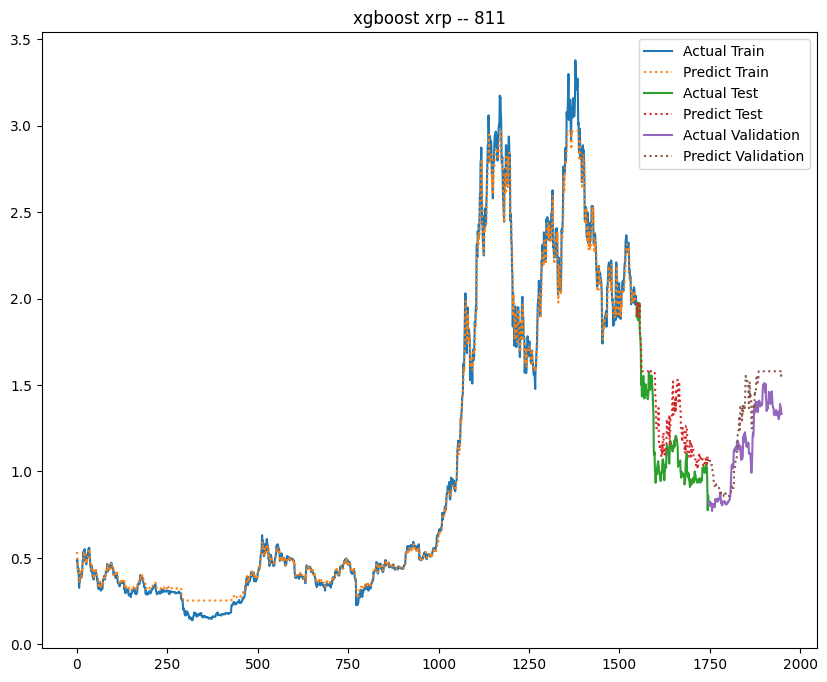

In [119]:
color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

plt.figure(figsize=(10, 8))

# train
train_range = range(0, len(y_true_train.squeeze()))
plt.plot([*train_range], y_true_train.squeeze(), label="Actual Train", color = color_palette[0])
plt.plot([*train_range], pred_train.squeeze(), label="Predict Train", linestyle="dotted", color = color_palette[1])

# test
test_range = range(train_range[-1] + 1, train_range[-1] + 1 + len(y_true_test.squeeze()))
plt.plot([*test_range], y_true_test.squeeze(), label="Actual Test", color=color_palette[2])
plt.plot([*test_range], pred_test.squeeze(), label="Predict Test", linestyle="dotted", color=color_palette[3])

# val
val_range = range(test_range[-1] + 1, test_range[-1] + 1 + len(y_true_val.squeeze()))
plt.plot([*val_range], y_true_val.squeeze(), label="Actual Validation", color=color_palette[4])
plt.plot([*val_range], pred_val.squeeze(), label="Predict Validation", linestyle="dotted",color=color_palette[5])

plt.legend()
plt.title(f"{model_name} {tokens[token_id]} -- {train_test_split[n_split]}")

save_folder = f"Figures/{tokens[token_id]}"
os.makedirs(f"{save_folder}", exist_ok=True)
plt.savefig(f"{save_folder}/{model_name}_{train_test_split[n_split]}.png")
plt.show()